In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score

import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression

In [2]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPoint
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics
import copy
#import tensorflow as tf

ModuleNotFoundError: No module named 'torch._C'

In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
#snps = df.drop_duplicates(subset=['not_sQTL'])['not_sQTL'].values
#res = pd.DataFrame({'Chr':[x.split(':')[0] for x in snps],'Pos':[int(x.split(':')[1]) for x in snps],'marker':snps})
#res.sort_values(['Chr','Pos'],ascending=True).to_csv('../Data/not_sQTL.gor',sep='\t',index=False)

In [3]:
rng = np.random.default_rng(23673)

In [4]:
data_dir = '../Data'

In [5]:
L = 32
N_GPUS = 8
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

In [6]:
SL=5000
CL_max=40000

In [7]:
lead_sQTL = pd.read_csv('/odinn/data/dataprocessing/rnasplice-blood/curry/sQTL_summary/lead_sQTL.gor', sep='\t')

In [8]:
lead_sQTL.columns

Index(['Chrom', 'Pos', 'Name', 'rsids', 'splice_event_id', 'Gene_name', 'Pval',
       'log10_Pval', 'Effect', 'X2', 'ImpMAF', 'ImpInfo', 'REF', 'ALT', 'Amaj',
       'Amin', 'Max_Impact', 'Max_Consequence', 'Startx', 'End', 'ClusterID',
       'Strand', 'jct_prevalence', 'is_annotated', 'donor', 'acceptor',
       'Pos_bin', 'num_tests'],
      dtype='object')

In [9]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/gene_boundries.pkl', 'rb') as f:
    gene_boundries = pickle.load(f)
    
def unionBoundry(names,gene_boundries):
    for i,name in enumerate(names):
        if i==0:
            gene_start,gene_end = gene_boundries[name]
        else:
            start,end = gene_boundries[name]
            gene_start,gene_end = np.min([gene_start,start]),np.max([gene_end,end])
    return gene_start,gene_end
inside_gene = []

def is_inside_gene(names,gene_boundries):
    inside_gene = []
    for i,name in enumerate(names):
        #if i==0:
        gene_start,gene_end = gene_boundries[name]
        #else:
        #    start,end = gene_boundries[name]
        #   gene_start,gene_end = np.min([gene_start,start]),np.max([gene_end,end])
        inside_gene.append(gene_start <= pos <= gene_end)
    
    return np.any(inside_gene)

#for i in tqdm(range(lead_sQTL.shape[0])):
#    gene,chrm,strand,pos,jn_start,jn_end,ref_s,alt_s,event_id = lead_sQTL.iloc[i,:][['Gene_name','Chrom','Strand','Pos','Startx','End','REF','ALT','splice_event_id']]
#    names = gene.split(',')
#    gene_start,gene_end = unionBoundry(names,gene_boundries)
#    inside_gene.append(gene_start <= pos <= gene_end)
inside_gene = []
for i in tqdm(range(lead_sQTL.shape[0])):
    gene,chrm,strand,pos,jn_start,jn_end,ref_s,alt_s,event_id = lead_sQTL.iloc[i,:][['Gene_name','Chrom','Strand','Pos','Startx','End','REF','ALT','splice_event_id']]
    names = gene.split(',')
    inside_gene.append(is_inside_gene(names,gene_boundries))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257372/257372 [03:03<00:00, 1400.13it/s]


In [10]:
#lead_sQTL = lead_sQTL[lead_sQTL['Max_Consequence']!='intergenic_variant']
#lead_sQTL = lead_sQTL[lead_sQTL['Pos_bin']!='distant_downstream']
#lead_sQTL = lead_sQTL[lead_sQTL['Pos_bin']!='distant_upstream']
lead_sQTL = lead_sQTL[inside_gene]
print(np.sum(lead_sQTL['REF']==lead_sQTL['ALT']))
lead_sQTL = lead_sQTL[lead_sQTL['REF']!=lead_sQTL['ALT']]
print(f'{0.05}/{lead_sQTL.shape[0]}')
print(np.sum(lead_sQTL['Pval']<=0.05/lead_sQTL.shape[0]))


16082
0.05/146372
80976


In [11]:
lead_sQTL = lead_sQTL[lead_sQTL['Pval']<=0.05/lead_sQTL.shape[0]]

In [12]:
import pyfastx
data_dir = '../Data/'
fasta_file_path = '../Data/genome.fa'
gtf_file_path = '../Data/Homo_sapiens.GRCh38.87.gtf'
fasta = pyfastx.Fasta(fasta_file_path)

In [15]:
NUM_ACCUMULATION_STEPS = 1
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

#if torch.cuda.device_count() > 1:
#    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]

[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()

RuntimeError: Error(s) in loading state_dict for SpliceFormer:
	Missing key(s) in state_dict: "SpliceAI.conv_layer_1.weight", "SpliceAI.conv_layer_1.bias", "SpliceAI.skip_layers.0.weight", "SpliceAI.skip_layers.0.bias", "SpliceAI.skip_layers.1.weight", "SpliceAI.skip_layers.1.bias", "SpliceAI.skip_layers.2.weight", "SpliceAI.skip_layers.2.bias", "SpliceAI.skip_layers.3.weight", "SpliceAI.skip_layers.3.bias", "SpliceAI.skip_layers.4.weight", "SpliceAI.skip_layers.4.bias", "SpliceAI.res_layers.0.comboBlock.0.convlayer1.weight", "SpliceAI.res_layers.0.comboBlock.0.convlayer1.bias", "SpliceAI.res_layers.0.comboBlock.0.convlayer2.weight", "SpliceAI.res_layers.0.comboBlock.0.convlayer2.bias", "SpliceAI.res_layers.0.comboBlock.0.bn1.weight", "SpliceAI.res_layers.0.comboBlock.0.bn1.bias", "SpliceAI.res_layers.0.comboBlock.0.bn1.running_mean", "SpliceAI.res_layers.0.comboBlock.0.bn1.running_var", "SpliceAI.res_layers.0.comboBlock.0.bn2.weight", "SpliceAI.res_layers.0.comboBlock.0.bn2.bias", "SpliceAI.res_layers.0.comboBlock.0.bn2.running_mean", "SpliceAI.res_layers.0.comboBlock.0.bn2.running_var", "SpliceAI.res_layers.0.comboBlock.1.convlayer1.weight", "SpliceAI.res_layers.0.comboBlock.1.convlayer1.bias", "SpliceAI.res_layers.0.comboBlock.1.convlayer2.weight", "SpliceAI.res_layers.0.comboBlock.1.convlayer2.bias", "SpliceAI.res_layers.0.comboBlock.1.bn1.weight", "SpliceAI.res_layers.0.comboBlock.1.bn1.bias", "SpliceAI.res_layers.0.comboBlock.1.bn1.running_mean", "SpliceAI.res_layers.0.comboBlock.1.bn1.running_var", "SpliceAI.res_layers.0.comboBlock.1.bn2.weight", "SpliceAI.res_layers.0.comboBlock.1.bn2.bias", "SpliceAI.res_layers.0.comboBlock.1.bn2.running_mean", "SpliceAI.res_layers.0.comboBlock.1.bn2.running_var", "SpliceAI.res_layers.0.comboBlock.2.convlayer1.weight", "SpliceAI.res_layers.0.comboBlock.2.convlayer1.bias", "SpliceAI.res_layers.0.comboBlock.2.convlayer2.weight", "SpliceAI.res_layers.0.comboBlock.2.convlayer2.bias", "SpliceAI.res_layers.0.comboBlock.2.bn1.weight", "SpliceAI.res_layers.0.comboBlock.2.bn1.bias", "SpliceAI.res_layers.0.comboBlock.2.bn1.running_mean", "SpliceAI.res_layers.0.comboBlock.2.bn1.running_var", "SpliceAI.res_layers.0.comboBlock.2.bn2.weight", "SpliceAI.res_layers.0.comboBlock.2.bn2.bias", "SpliceAI.res_layers.0.comboBlock.2.bn2.running_mean", "SpliceAI.res_layers.0.comboBlock.2.bn2.running_var", "SpliceAI.res_layers.0.comboBlock.3.convlayer1.weight", "SpliceAI.res_layers.0.comboBlock.3.convlayer1.bias", "SpliceAI.res_layers.0.comboBlock.3.convlayer2.weight", "SpliceAI.res_layers.0.comboBlock.3.convlayer2.bias", "SpliceAI.res_layers.0.comboBlock.3.bn1.weight", "SpliceAI.res_layers.0.comboBlock.3.bn1.bias", "SpliceAI.res_layers.0.comboBlock.3.bn1.running_mean", "SpliceAI.res_layers.0.comboBlock.3.bn1.running_var", "SpliceAI.res_layers.0.comboBlock.3.bn2.weight", "SpliceAI.res_layers.0.comboBlock.3.bn2.bias", "SpliceAI.res_layers.0.comboBlock.3.bn2.running_mean", "SpliceAI.res_layers.0.comboBlock.3.bn2.running_var", "SpliceAI.res_layers.1.comboBlock.0.convlayer1.weight", "SpliceAI.res_layers.1.comboBlock.0.convlayer1.bias", "SpliceAI.res_layers.1.comboBlock.0.convlayer2.weight", "SpliceAI.res_layers.1.comboBlock.0.convlayer2.bias", "SpliceAI.res_layers.1.comboBlock.0.bn1.weight", "SpliceAI.res_layers.1.comboBlock.0.bn1.bias", "SpliceAI.res_layers.1.comboBlock.0.bn1.running_mean", "SpliceAI.res_layers.1.comboBlock.0.bn1.running_var", "SpliceAI.res_layers.1.comboBlock.0.bn2.weight", "SpliceAI.res_layers.1.comboBlock.0.bn2.bias", "SpliceAI.res_layers.1.comboBlock.0.bn2.running_mean", "SpliceAI.res_layers.1.comboBlock.0.bn2.running_var", "SpliceAI.res_layers.1.comboBlock.1.convlayer1.weight", "SpliceAI.res_layers.1.comboBlock.1.convlayer1.bias", "SpliceAI.res_layers.1.comboBlock.1.convlayer2.weight", "SpliceAI.res_layers.1.comboBlock.1.convlayer2.bias", "SpliceAI.res_layers.1.comboBlock.1.bn1.weight", "SpliceAI.res_layers.1.comboBlock.1.bn1.bias", "SpliceAI.res_layers.1.comboBlock.1.bn1.running_mean", "SpliceAI.res_layers.1.comboBlock.1.bn1.running_var", "SpliceAI.res_layers.1.comboBlock.1.bn2.weight", "SpliceAI.res_layers.1.comboBlock.1.bn2.bias", "SpliceAI.res_layers.1.comboBlock.1.bn2.running_mean", "SpliceAI.res_layers.1.comboBlock.1.bn2.running_var", "SpliceAI.res_layers.1.comboBlock.2.convlayer1.weight", "SpliceAI.res_layers.1.comboBlock.2.convlayer1.bias", "SpliceAI.res_layers.1.comboBlock.2.convlayer2.weight", "SpliceAI.res_layers.1.comboBlock.2.convlayer2.bias", "SpliceAI.res_layers.1.comboBlock.2.bn1.weight", "SpliceAI.res_layers.1.comboBlock.2.bn1.bias", "SpliceAI.res_layers.1.comboBlock.2.bn1.running_mean", "SpliceAI.res_layers.1.comboBlock.2.bn1.running_var", "SpliceAI.res_layers.1.comboBlock.2.bn2.weight", "SpliceAI.res_layers.1.comboBlock.2.bn2.bias", "SpliceAI.res_layers.1.comboBlock.2.bn2.running_mean", "SpliceAI.res_layers.1.comboBlock.2.bn2.running_var", "SpliceAI.res_layers.1.comboBlock.3.convlayer1.weight", "SpliceAI.res_layers.1.comboBlock.3.convlayer1.bias", "SpliceAI.res_layers.1.comboBlock.3.convlayer2.weight", "SpliceAI.res_layers.1.comboBlock.3.convlayer2.bias", "SpliceAI.res_layers.1.comboBlock.3.bn1.weight", "SpliceAI.res_layers.1.comboBlock.3.bn1.bias", "SpliceAI.res_layers.1.comboBlock.3.bn1.running_mean", "SpliceAI.res_layers.1.comboBlock.3.bn1.running_var", "SpliceAI.res_layers.1.comboBlock.3.bn2.weight", "SpliceAI.res_layers.1.comboBlock.3.bn2.bias", "SpliceAI.res_layers.1.comboBlock.3.bn2.running_mean", "SpliceAI.res_layers.1.comboBlock.3.bn2.running_var", "SpliceAI.res_layers.2.comboBlock.0.convlayer1.weight", "SpliceAI.res_layers.2.comboBlock.0.convlayer1.bias", "SpliceAI.res_layers.2.comboBlock.0.convlayer2.weight", "SpliceAI.res_layers.2.comboBlock.0.convlayer2.bias", "SpliceAI.res_layers.2.comboBlock.0.bn1.weight", "SpliceAI.res_layers.2.comboBlock.0.bn1.bias", "SpliceAI.res_layers.2.comboBlock.0.bn1.running_mean", "SpliceAI.res_layers.2.comboBlock.0.bn1.running_var", "SpliceAI.res_layers.2.comboBlock.0.bn2.weight", "SpliceAI.res_layers.2.comboBlock.0.bn2.bias", "SpliceAI.res_layers.2.comboBlock.0.bn2.running_mean", "SpliceAI.res_layers.2.comboBlock.0.bn2.running_var", "SpliceAI.res_layers.2.comboBlock.1.convlayer1.weight", "SpliceAI.res_layers.2.comboBlock.1.convlayer1.bias", "SpliceAI.res_layers.2.comboBlock.1.convlayer2.weight", "SpliceAI.res_layers.2.comboBlock.1.convlayer2.bias", "SpliceAI.res_layers.2.comboBlock.1.bn1.weight", "SpliceAI.res_layers.2.comboBlock.1.bn1.bias", "SpliceAI.res_layers.2.comboBlock.1.bn1.running_mean", "SpliceAI.res_layers.2.comboBlock.1.bn1.running_var", "SpliceAI.res_layers.2.comboBlock.1.bn2.weight", "SpliceAI.res_layers.2.comboBlock.1.bn2.bias", "SpliceAI.res_layers.2.comboBlock.1.bn2.running_mean", "SpliceAI.res_layers.2.comboBlock.1.bn2.running_var", "SpliceAI.res_layers.2.comboBlock.2.convlayer1.weight", "SpliceAI.res_layers.2.comboBlock.2.convlayer1.bias", "SpliceAI.res_layers.2.comboBlock.2.convlayer2.weight", "SpliceAI.res_layers.2.comboBlock.2.convlayer2.bias", "SpliceAI.res_layers.2.comboBlock.2.bn1.weight", "SpliceAI.res_layers.2.comboBlock.2.bn1.bias", "SpliceAI.res_layers.2.comboBlock.2.bn1.running_mean", "SpliceAI.res_layers.2.comboBlock.2.bn1.running_var", "SpliceAI.res_layers.2.comboBlock.2.bn2.weight", "SpliceAI.res_layers.2.comboBlock.2.bn2.bias", "SpliceAI.res_layers.2.comboBlock.2.bn2.running_mean", "SpliceAI.res_layers.2.comboBlock.2.bn2.running_var", "SpliceAI.res_layers.2.comboBlock.3.convlayer1.weight", "SpliceAI.res_layers.2.comboBlock.3.convlayer1.bias", "SpliceAI.res_layers.2.comboBlock.3.convlayer2.weight", "SpliceAI.res_layers.2.comboBlock.3.convlayer2.bias", "SpliceAI.res_layers.2.comboBlock.3.bn1.weight", "SpliceAI.res_layers.2.comboBlock.3.bn1.bias", "SpliceAI.res_layers.2.comboBlock.3.bn1.running_mean", "SpliceAI.res_layers.2.comboBlock.3.bn1.running_var", "SpliceAI.res_layers.2.comboBlock.3.bn2.weight", "SpliceAI.res_layers.2.comboBlock.3.bn2.bias", "SpliceAI.res_layers.2.comboBlock.3.bn2.running_mean", "SpliceAI.res_layers.2.comboBlock.3.bn2.running_var", "SpliceAI.res_layers.3.comboBlock.0.convlayer1.weight", "SpliceAI.res_layers.3.comboBlock.0.convlayer1.bias", "SpliceAI.res_layers.3.comboBlock.0.convlayer2.weight", "SpliceAI.res_layers.3.comboBlock.0.convlayer2.bias", "SpliceAI.res_layers.3.comboBlock.0.bn1.weight", "SpliceAI.res_layers.3.comboBlock.0.bn1.bias", "SpliceAI.res_layers.3.comboBlock.0.bn1.running_mean", "SpliceAI.res_layers.3.comboBlock.0.bn1.running_var", "SpliceAI.res_layers.3.comboBlock.0.bn2.weight", "SpliceAI.res_layers.3.comboBlock.0.bn2.bias", "SpliceAI.res_layers.3.comboBlock.0.bn2.running_mean", "SpliceAI.res_layers.3.comboBlock.0.bn2.running_var", "SpliceAI.res_layers.3.comboBlock.1.convlayer1.weight", "SpliceAI.res_layers.3.comboBlock.1.convlayer1.bias", "SpliceAI.res_layers.3.comboBlock.1.convlayer2.weight", "SpliceAI.res_layers.3.comboBlock.1.convlayer2.bias", "SpliceAI.res_layers.3.comboBlock.1.bn1.weight", "SpliceAI.res_layers.3.comboBlock.1.bn1.bias", "SpliceAI.res_layers.3.comboBlock.1.bn1.running_mean", "SpliceAI.res_layers.3.comboBlock.1.bn1.running_var", "SpliceAI.res_layers.3.comboBlock.1.bn2.weight", "SpliceAI.res_layers.3.comboBlock.1.bn2.bias", "SpliceAI.res_layers.3.comboBlock.1.bn2.running_mean", "SpliceAI.res_layers.3.comboBlock.1.bn2.running_var", "SpliceAI.res_layers.3.comboBlock.2.convlayer1.weight", "SpliceAI.res_layers.3.comboBlock.2.convlayer1.bias", "SpliceAI.res_layers.3.comboBlock.2.convlayer2.weight", "SpliceAI.res_layers.3.comboBlock.2.convlayer2.bias", "SpliceAI.res_layers.3.comboBlock.2.bn1.weight", "SpliceAI.res_layers.3.comboBlock.2.bn1.bias", "SpliceAI.res_layers.3.comboBlock.2.bn1.running_mean", "SpliceAI.res_layers.3.comboBlock.2.bn1.running_var", "SpliceAI.res_layers.3.comboBlock.2.bn2.weight", "SpliceAI.res_layers.3.comboBlock.2.bn2.bias", "SpliceAI.res_layers.3.comboBlock.2.bn2.running_mean", "SpliceAI.res_layers.3.comboBlock.2.bn2.running_var", "SpliceAI.res_layers.3.comboBlock.3.convlayer1.weight", "SpliceAI.res_layers.3.comboBlock.3.convlayer1.bias", "SpliceAI.res_layers.3.comboBlock.3.convlayer2.weight", "SpliceAI.res_layers.3.comboBlock.3.convlayer2.bias", "SpliceAI.res_layers.3.comboBlock.3.bn1.weight", "SpliceAI.res_layers.3.comboBlock.3.bn1.bias", "SpliceAI.res_layers.3.comboBlock.3.bn1.running_mean", "SpliceAI.res_layers.3.comboBlock.3.bn1.running_var", "SpliceAI.res_layers.3.comboBlock.3.bn2.weight", "SpliceAI.res_layers.3.comboBlock.3.bn2.bias", "SpliceAI.res_layers.3.comboBlock.3.bn2.running_mean", "SpliceAI.res_layers.3.comboBlock.3.bn2.running_var", "conv_final.weight", "conv_final.bias", "policy.affine1.weight", "policy.affine1.bias", "policy.affine2.weight", "policy.affine2.bias", "skip_layers.0.weight", "skip_layers.0.bias", "skip_layers.1.weight", "skip_layers.1.bias", "skip_layers.2.weight", "skip_layers.2.bias", "transformerBlocks.0.layers.0.0.to_qkv.weight", "transformerBlocks.0.layers.0.0.gate.weight", "transformerBlocks.0.layers.0.0.gate.bias", "transformerBlocks.0.layers.0.0.to_out.0.weight", "transformerBlocks.0.layers.0.0.to_out.0.bias", "transformerBlocks.0.layers.0.1.net.0.weight", "transformerBlocks.0.layers.0.1.net.0.bias", "transformerBlocks.0.layers.0.1.net.3.weight", "transformerBlocks.0.layers.0.1.net.3.bias", "transformerBlocks.0.layers.1.0.to_qkv.weight", "transformerBlocks.0.layers.1.0.gate.weight", "transformerBlocks.0.layers.1.0.gate.bias", "transformerBlocks.0.layers.1.0.to_out.0.weight", "transformerBlocks.0.layers.1.0.to_out.0.bias", "transformerBlocks.0.layers.1.1.net.0.weight", "transformerBlocks.0.layers.1.1.net.0.bias", "transformerBlocks.0.layers.1.1.net.3.weight", "transformerBlocks.0.layers.1.1.net.3.bias", "transformerBlocks.0.layers.2.0.to_qkv.weight", "transformerBlocks.0.layers.2.0.gate.weight", "transformerBlocks.0.layers.2.0.gate.bias", "transformerBlocks.0.layers.2.0.to_out.0.weight", "transformerBlocks.0.layers.2.0.to_out.0.bias", "transformerBlocks.0.layers.2.1.net.0.weight", "transformerBlocks.0.layers.2.1.net.0.bias", "transformerBlocks.0.layers.2.1.net.3.weight", "transformerBlocks.0.layers.2.1.net.3.bias", "transformerBlocks.0.layers.3.0.to_qkv.weight", "transformerBlocks.0.layers.3.0.gate.weight", "transformerBlocks.0.layers.3.0.gate.bias", "transformerBlocks.0.layers.3.0.to_out.0.weight", "transformerBlocks.0.layers.3.0.to_out.0.bias", "transformerBlocks.0.layers.3.1.net.0.weight", "transformerBlocks.0.layers.3.1.net.0.bias", "transformerBlocks.0.layers.3.1.net.3.weight", "transformerBlocks.0.layers.3.1.net.3.bias", "transformerBlocks.0.layerNormLayers.0.0.weight", "transformerBlocks.0.layerNormLayers.0.0.bias", "transformerBlocks.0.layerNormLayers.0.1.weight", "transformerBlocks.0.layerNormLayers.0.1.bias", "transformerBlocks.0.layerNormLayers.1.0.weight", "transformerBlocks.0.layerNormLayers.1.0.bias", "transformerBlocks.0.layerNormLayers.1.1.weight", "transformerBlocks.0.layerNormLayers.1.1.bias", "transformerBlocks.0.layerNormLayers.2.0.weight", "transformerBlocks.0.layerNormLayers.2.0.bias", "transformerBlocks.0.layerNormLayers.2.1.weight", "transformerBlocks.0.layerNormLayers.2.1.bias", "transformerBlocks.0.layerNormLayers.3.0.weight", "transformerBlocks.0.layerNormLayers.3.0.bias", "transformerBlocks.0.layerNormLayers.3.1.weight", "transformerBlocks.0.layerNormLayers.3.1.bias", "transformerBlocks.0.pos_emb.inv_freq", "transformerBlocks.1.layers.0.0.to_qkv.weight", "transformerBlocks.1.layers.0.0.gate.weight", "transformerBlocks.1.layers.0.0.gate.bias", "transformerBlocks.1.layers.0.0.to_out.0.weight", "transformerBlocks.1.layers.0.0.to_out.0.bias", "transformerBlocks.1.layers.0.1.net.0.weight", "transformerBlocks.1.layers.0.1.net.0.bias", "transformerBlocks.1.layers.0.1.net.3.weight", "transformerBlocks.1.layers.0.1.net.3.bias", "transformerBlocks.1.layers.1.0.to_qkv.weight", "transformerBlocks.1.layers.1.0.gate.weight", "transformerBlocks.1.layers.1.0.gate.bias", "transformerBlocks.1.layers.1.0.to_out.0.weight", "transformerBlocks.1.layers.1.0.to_out.0.bias", "transformerBlocks.1.layers.1.1.net.0.weight", "transformerBlocks.1.layers.1.1.net.0.bias", "transformerBlocks.1.layers.1.1.net.3.weight", "transformerBlocks.1.layers.1.1.net.3.bias", "transformerBlocks.1.layers.2.0.to_qkv.weight", "transformerBlocks.1.layers.2.0.gate.weight", "transformerBlocks.1.layers.2.0.gate.bias", "transformerBlocks.1.layers.2.0.to_out.0.weight", "transformerBlocks.1.layers.2.0.to_out.0.bias", "transformerBlocks.1.layers.2.1.net.0.weight", "transformerBlocks.1.layers.2.1.net.0.bias", "transformerBlocks.1.layers.2.1.net.3.weight", "transformerBlocks.1.layers.2.1.net.3.bias", "transformerBlocks.1.layers.3.0.to_qkv.weight", "transformerBlocks.1.layers.3.0.gate.weight", "transformerBlocks.1.layers.3.0.gate.bias", "transformerBlocks.1.layers.3.0.to_out.0.weight", "transformerBlocks.1.layers.3.0.to_out.0.bias", "transformerBlocks.1.layers.3.1.net.0.weight", "transformerBlocks.1.layers.3.1.net.0.bias", "transformerBlocks.1.layers.3.1.net.3.weight", "transformerBlocks.1.layers.3.1.net.3.bias", "transformerBlocks.1.layerNormLayers.0.0.weight", "transformerBlocks.1.layerNormLayers.0.0.bias", "transformerBlocks.1.layerNormLayers.0.1.weight", "transformerBlocks.1.layerNormLayers.0.1.bias", "transformerBlocks.1.layerNormLayers.1.0.weight", "transformerBlocks.1.layerNormLayers.1.0.bias", "transformerBlocks.1.layerNormLayers.1.1.weight", "transformerBlocks.1.layerNormLayers.1.1.bias", "transformerBlocks.1.layerNormLayers.2.0.weight", "transformerBlocks.1.layerNormLayers.2.0.bias", "transformerBlocks.1.layerNormLayers.2.1.weight", "transformerBlocks.1.layerNormLayers.2.1.bias", "transformerBlocks.1.layerNormLayers.3.0.weight", "transformerBlocks.1.layerNormLayers.3.0.bias", "transformerBlocks.1.layerNormLayers.3.1.weight", "transformerBlocks.1.layerNormLayers.3.1.bias", "transformerBlocks.1.pos_emb.inv_freq". 
	Unexpected key(s) in state_dict: "module.SpliceAI.conv_layer_1.weight", "module.SpliceAI.conv_layer_1.bias", "module.SpliceAI.skip_layers.0.weight", "module.SpliceAI.skip_layers.0.bias", "module.SpliceAI.skip_layers.1.weight", "module.SpliceAI.skip_layers.1.bias", "module.SpliceAI.skip_layers.2.weight", "module.SpliceAI.skip_layers.2.bias", "module.SpliceAI.skip_layers.3.weight", "module.SpliceAI.skip_layers.3.bias", "module.SpliceAI.skip_layers.4.weight", "module.SpliceAI.skip_layers.4.bias", "module.SpliceAI.res_layers.0.comboBlock.0.convlayer1.weight", "module.SpliceAI.res_layers.0.comboBlock.0.convlayer1.bias", "module.SpliceAI.res_layers.0.comboBlock.0.convlayer2.weight", "module.SpliceAI.res_layers.0.comboBlock.0.convlayer2.bias", "module.SpliceAI.res_layers.0.comboBlock.0.bn1.weight", "module.SpliceAI.res_layers.0.comboBlock.0.bn1.bias", "module.SpliceAI.res_layers.0.comboBlock.0.bn1.running_mean", "module.SpliceAI.res_layers.0.comboBlock.0.bn1.running_var", "module.SpliceAI.res_layers.0.comboBlock.0.bn1.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.0.bn2.weight", "module.SpliceAI.res_layers.0.comboBlock.0.bn2.bias", "module.SpliceAI.res_layers.0.comboBlock.0.bn2.running_mean", "module.SpliceAI.res_layers.0.comboBlock.0.bn2.running_var", "module.SpliceAI.res_layers.0.comboBlock.0.bn2.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.1.convlayer1.weight", "module.SpliceAI.res_layers.0.comboBlock.1.convlayer1.bias", "module.SpliceAI.res_layers.0.comboBlock.1.convlayer2.weight", "module.SpliceAI.res_layers.0.comboBlock.1.convlayer2.bias", "module.SpliceAI.res_layers.0.comboBlock.1.bn1.weight", "module.SpliceAI.res_layers.0.comboBlock.1.bn1.bias", "module.SpliceAI.res_layers.0.comboBlock.1.bn1.running_mean", "module.SpliceAI.res_layers.0.comboBlock.1.bn1.running_var", "module.SpliceAI.res_layers.0.comboBlock.1.bn1.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.1.bn2.weight", "module.SpliceAI.res_layers.0.comboBlock.1.bn2.bias", "module.SpliceAI.res_layers.0.comboBlock.1.bn2.running_mean", "module.SpliceAI.res_layers.0.comboBlock.1.bn2.running_var", "module.SpliceAI.res_layers.0.comboBlock.1.bn2.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.2.convlayer1.weight", "module.SpliceAI.res_layers.0.comboBlock.2.convlayer1.bias", "module.SpliceAI.res_layers.0.comboBlock.2.convlayer2.weight", "module.SpliceAI.res_layers.0.comboBlock.2.convlayer2.bias", "module.SpliceAI.res_layers.0.comboBlock.2.bn1.weight", "module.SpliceAI.res_layers.0.comboBlock.2.bn1.bias", "module.SpliceAI.res_layers.0.comboBlock.2.bn1.running_mean", "module.SpliceAI.res_layers.0.comboBlock.2.bn1.running_var", "module.SpliceAI.res_layers.0.comboBlock.2.bn1.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.2.bn2.weight", "module.SpliceAI.res_layers.0.comboBlock.2.bn2.bias", "module.SpliceAI.res_layers.0.comboBlock.2.bn2.running_mean", "module.SpliceAI.res_layers.0.comboBlock.2.bn2.running_var", "module.SpliceAI.res_layers.0.comboBlock.2.bn2.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.3.convlayer1.weight", "module.SpliceAI.res_layers.0.comboBlock.3.convlayer1.bias", "module.SpliceAI.res_layers.0.comboBlock.3.convlayer2.weight", "module.SpliceAI.res_layers.0.comboBlock.3.convlayer2.bias", "module.SpliceAI.res_layers.0.comboBlock.3.bn1.weight", "module.SpliceAI.res_layers.0.comboBlock.3.bn1.bias", "module.SpliceAI.res_layers.0.comboBlock.3.bn1.running_mean", "module.SpliceAI.res_layers.0.comboBlock.3.bn1.running_var", "module.SpliceAI.res_layers.0.comboBlock.3.bn1.num_batches_tracked", "module.SpliceAI.res_layers.0.comboBlock.3.bn2.weight", "module.SpliceAI.res_layers.0.comboBlock.3.bn2.bias", "module.SpliceAI.res_layers.0.comboBlock.3.bn2.running_mean", "module.SpliceAI.res_layers.0.comboBlock.3.bn2.running_var", "module.SpliceAI.res_layers.0.comboBlock.3.bn2.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.0.convlayer1.weight", "module.SpliceAI.res_layers.1.comboBlock.0.convlayer1.bias", "module.SpliceAI.res_layers.1.comboBlock.0.convlayer2.weight", "module.SpliceAI.res_layers.1.comboBlock.0.convlayer2.bias", "module.SpliceAI.res_layers.1.comboBlock.0.bn1.weight", "module.SpliceAI.res_layers.1.comboBlock.0.bn1.bias", "module.SpliceAI.res_layers.1.comboBlock.0.bn1.running_mean", "module.SpliceAI.res_layers.1.comboBlock.0.bn1.running_var", "module.SpliceAI.res_layers.1.comboBlock.0.bn1.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.0.bn2.weight", "module.SpliceAI.res_layers.1.comboBlock.0.bn2.bias", "module.SpliceAI.res_layers.1.comboBlock.0.bn2.running_mean", "module.SpliceAI.res_layers.1.comboBlock.0.bn2.running_var", "module.SpliceAI.res_layers.1.comboBlock.0.bn2.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.1.convlayer1.weight", "module.SpliceAI.res_layers.1.comboBlock.1.convlayer1.bias", "module.SpliceAI.res_layers.1.comboBlock.1.convlayer2.weight", "module.SpliceAI.res_layers.1.comboBlock.1.convlayer2.bias", "module.SpliceAI.res_layers.1.comboBlock.1.bn1.weight", "module.SpliceAI.res_layers.1.comboBlock.1.bn1.bias", "module.SpliceAI.res_layers.1.comboBlock.1.bn1.running_mean", "module.SpliceAI.res_layers.1.comboBlock.1.bn1.running_var", "module.SpliceAI.res_layers.1.comboBlock.1.bn1.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.1.bn2.weight", "module.SpliceAI.res_layers.1.comboBlock.1.bn2.bias", "module.SpliceAI.res_layers.1.comboBlock.1.bn2.running_mean", "module.SpliceAI.res_layers.1.comboBlock.1.bn2.running_var", "module.SpliceAI.res_layers.1.comboBlock.1.bn2.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.2.convlayer1.weight", "module.SpliceAI.res_layers.1.comboBlock.2.convlayer1.bias", "module.SpliceAI.res_layers.1.comboBlock.2.convlayer2.weight", "module.SpliceAI.res_layers.1.comboBlock.2.convlayer2.bias", "module.SpliceAI.res_layers.1.comboBlock.2.bn1.weight", "module.SpliceAI.res_layers.1.comboBlock.2.bn1.bias", "module.SpliceAI.res_layers.1.comboBlock.2.bn1.running_mean", "module.SpliceAI.res_layers.1.comboBlock.2.bn1.running_var", "module.SpliceAI.res_layers.1.comboBlock.2.bn1.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.2.bn2.weight", "module.SpliceAI.res_layers.1.comboBlock.2.bn2.bias", "module.SpliceAI.res_layers.1.comboBlock.2.bn2.running_mean", "module.SpliceAI.res_layers.1.comboBlock.2.bn2.running_var", "module.SpliceAI.res_layers.1.comboBlock.2.bn2.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.3.convlayer1.weight", "module.SpliceAI.res_layers.1.comboBlock.3.convlayer1.bias", "module.SpliceAI.res_layers.1.comboBlock.3.convlayer2.weight", "module.SpliceAI.res_layers.1.comboBlock.3.convlayer2.bias", "module.SpliceAI.res_layers.1.comboBlock.3.bn1.weight", "module.SpliceAI.res_layers.1.comboBlock.3.bn1.bias", "module.SpliceAI.res_layers.1.comboBlock.3.bn1.running_mean", "module.SpliceAI.res_layers.1.comboBlock.3.bn1.running_var", "module.SpliceAI.res_layers.1.comboBlock.3.bn1.num_batches_tracked", "module.SpliceAI.res_layers.1.comboBlock.3.bn2.weight", "module.SpliceAI.res_layers.1.comboBlock.3.bn2.bias", "module.SpliceAI.res_layers.1.comboBlock.3.bn2.running_mean", "module.SpliceAI.res_layers.1.comboBlock.3.bn2.running_var", "module.SpliceAI.res_layers.1.comboBlock.3.bn2.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.0.convlayer1.weight", "module.SpliceAI.res_layers.2.comboBlock.0.convlayer1.bias", "module.SpliceAI.res_layers.2.comboBlock.0.convlayer2.weight", "module.SpliceAI.res_layers.2.comboBlock.0.convlayer2.bias", "module.SpliceAI.res_layers.2.comboBlock.0.bn1.weight", "module.SpliceAI.res_layers.2.comboBlock.0.bn1.bias", "module.SpliceAI.res_layers.2.comboBlock.0.bn1.running_mean", "module.SpliceAI.res_layers.2.comboBlock.0.bn1.running_var", "module.SpliceAI.res_layers.2.comboBlock.0.bn1.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.0.bn2.weight", "module.SpliceAI.res_layers.2.comboBlock.0.bn2.bias", "module.SpliceAI.res_layers.2.comboBlock.0.bn2.running_mean", "module.SpliceAI.res_layers.2.comboBlock.0.bn2.running_var", "module.SpliceAI.res_layers.2.comboBlock.0.bn2.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.1.convlayer1.weight", "module.SpliceAI.res_layers.2.comboBlock.1.convlayer1.bias", "module.SpliceAI.res_layers.2.comboBlock.1.convlayer2.weight", "module.SpliceAI.res_layers.2.comboBlock.1.convlayer2.bias", "module.SpliceAI.res_layers.2.comboBlock.1.bn1.weight", "module.SpliceAI.res_layers.2.comboBlock.1.bn1.bias", "module.SpliceAI.res_layers.2.comboBlock.1.bn1.running_mean", "module.SpliceAI.res_layers.2.comboBlock.1.bn1.running_var", "module.SpliceAI.res_layers.2.comboBlock.1.bn1.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.1.bn2.weight", "module.SpliceAI.res_layers.2.comboBlock.1.bn2.bias", "module.SpliceAI.res_layers.2.comboBlock.1.bn2.running_mean", "module.SpliceAI.res_layers.2.comboBlock.1.bn2.running_var", "module.SpliceAI.res_layers.2.comboBlock.1.bn2.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.2.convlayer1.weight", "module.SpliceAI.res_layers.2.comboBlock.2.convlayer1.bias", "module.SpliceAI.res_layers.2.comboBlock.2.convlayer2.weight", "module.SpliceAI.res_layers.2.comboBlock.2.convlayer2.bias", "module.SpliceAI.res_layers.2.comboBlock.2.bn1.weight", "module.SpliceAI.res_layers.2.comboBlock.2.bn1.bias", "module.SpliceAI.res_layers.2.comboBlock.2.bn1.running_mean", "module.SpliceAI.res_layers.2.comboBlock.2.bn1.running_var", "module.SpliceAI.res_layers.2.comboBlock.2.bn1.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.2.bn2.weight", "module.SpliceAI.res_layers.2.comboBlock.2.bn2.bias", "module.SpliceAI.res_layers.2.comboBlock.2.bn2.running_mean", "module.SpliceAI.res_layers.2.comboBlock.2.bn2.running_var", "module.SpliceAI.res_layers.2.comboBlock.2.bn2.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.3.convlayer1.weight", "module.SpliceAI.res_layers.2.comboBlock.3.convlayer1.bias", "module.SpliceAI.res_layers.2.comboBlock.3.convlayer2.weight", "module.SpliceAI.res_layers.2.comboBlock.3.convlayer2.bias", "module.SpliceAI.res_layers.2.comboBlock.3.bn1.weight", "module.SpliceAI.res_layers.2.comboBlock.3.bn1.bias", "module.SpliceAI.res_layers.2.comboBlock.3.bn1.running_mean", "module.SpliceAI.res_layers.2.comboBlock.3.bn1.running_var", "module.SpliceAI.res_layers.2.comboBlock.3.bn1.num_batches_tracked", "module.SpliceAI.res_layers.2.comboBlock.3.bn2.weight", "module.SpliceAI.res_layers.2.comboBlock.3.bn2.bias", "module.SpliceAI.res_layers.2.comboBlock.3.bn2.running_mean", "module.SpliceAI.res_layers.2.comboBlock.3.bn2.running_var", "module.SpliceAI.res_layers.2.comboBlock.3.bn2.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.0.convlayer1.weight", "module.SpliceAI.res_layers.3.comboBlock.0.convlayer1.bias", "module.SpliceAI.res_layers.3.comboBlock.0.convlayer2.weight", "module.SpliceAI.res_layers.3.comboBlock.0.convlayer2.bias", "module.SpliceAI.res_layers.3.comboBlock.0.bn1.weight", "module.SpliceAI.res_layers.3.comboBlock.0.bn1.bias", "module.SpliceAI.res_layers.3.comboBlock.0.bn1.running_mean", "module.SpliceAI.res_layers.3.comboBlock.0.bn1.running_var", "module.SpliceAI.res_layers.3.comboBlock.0.bn1.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.0.bn2.weight", "module.SpliceAI.res_layers.3.comboBlock.0.bn2.bias", "module.SpliceAI.res_layers.3.comboBlock.0.bn2.running_mean", "module.SpliceAI.res_layers.3.comboBlock.0.bn2.running_var", "module.SpliceAI.res_layers.3.comboBlock.0.bn2.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.1.convlayer1.weight", "module.SpliceAI.res_layers.3.comboBlock.1.convlayer1.bias", "module.SpliceAI.res_layers.3.comboBlock.1.convlayer2.weight", "module.SpliceAI.res_layers.3.comboBlock.1.convlayer2.bias", "module.SpliceAI.res_layers.3.comboBlock.1.bn1.weight", "module.SpliceAI.res_layers.3.comboBlock.1.bn1.bias", "module.SpliceAI.res_layers.3.comboBlock.1.bn1.running_mean", "module.SpliceAI.res_layers.3.comboBlock.1.bn1.running_var", "module.SpliceAI.res_layers.3.comboBlock.1.bn1.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.1.bn2.weight", "module.SpliceAI.res_layers.3.comboBlock.1.bn2.bias", "module.SpliceAI.res_layers.3.comboBlock.1.bn2.running_mean", "module.SpliceAI.res_layers.3.comboBlock.1.bn2.running_var", "module.SpliceAI.res_layers.3.comboBlock.1.bn2.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.2.convlayer1.weight", "module.SpliceAI.res_layers.3.comboBlock.2.convlayer1.bias", "module.SpliceAI.res_layers.3.comboBlock.2.convlayer2.weight", "module.SpliceAI.res_layers.3.comboBlock.2.convlayer2.bias", "module.SpliceAI.res_layers.3.comboBlock.2.bn1.weight", "module.SpliceAI.res_layers.3.comboBlock.2.bn1.bias", "module.SpliceAI.res_layers.3.comboBlock.2.bn1.running_mean", "module.SpliceAI.res_layers.3.comboBlock.2.bn1.running_var", "module.SpliceAI.res_layers.3.comboBlock.2.bn1.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.2.bn2.weight", "module.SpliceAI.res_layers.3.comboBlock.2.bn2.bias", "module.SpliceAI.res_layers.3.comboBlock.2.bn2.running_mean", "module.SpliceAI.res_layers.3.comboBlock.2.bn2.running_var", "module.SpliceAI.res_layers.3.comboBlock.2.bn2.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.3.convlayer1.weight", "module.SpliceAI.res_layers.3.comboBlock.3.convlayer1.bias", "module.SpliceAI.res_layers.3.comboBlock.3.convlayer2.weight", "module.SpliceAI.res_layers.3.comboBlock.3.convlayer2.bias", "module.SpliceAI.res_layers.3.comboBlock.3.bn1.weight", "module.SpliceAI.res_layers.3.comboBlock.3.bn1.bias", "module.SpliceAI.res_layers.3.comboBlock.3.bn1.running_mean", "module.SpliceAI.res_layers.3.comboBlock.3.bn1.running_var", "module.SpliceAI.res_layers.3.comboBlock.3.bn1.num_batches_tracked", "module.SpliceAI.res_layers.3.comboBlock.3.bn2.weight", "module.SpliceAI.res_layers.3.comboBlock.3.bn2.bias", "module.SpliceAI.res_layers.3.comboBlock.3.bn2.running_mean", "module.SpliceAI.res_layers.3.comboBlock.3.bn2.running_var", "module.SpliceAI.res_layers.3.comboBlock.3.bn2.num_batches_tracked", "module.conv_final.weight", "module.conv_final.bias", "module.policy.affine1.weight", "module.policy.affine1.bias", "module.policy.affine2.weight", "module.policy.affine2.bias", "module.skip_layers.0.weight", "module.skip_layers.0.bias", "module.skip_layers.1.weight", "module.skip_layers.1.bias", "module.skip_layers.2.weight", "module.skip_layers.2.bias", "module.transformerBlocks.0.layers.0.0.to_qkv.weight", "module.transformerBlocks.0.layers.0.0.gate.weight", "module.transformerBlocks.0.layers.0.0.gate.bias", "module.transformerBlocks.0.layers.0.0.to_out.0.weight", "module.transformerBlocks.0.layers.0.0.to_out.0.bias", "module.transformerBlocks.0.layers.0.1.net.0.weight", "module.transformerBlocks.0.layers.0.1.net.0.bias", "module.transformerBlocks.0.layers.0.1.net.3.weight", "module.transformerBlocks.0.layers.0.1.net.3.bias", "module.transformerBlocks.0.layers.1.0.to_qkv.weight", "module.transformerBlocks.0.layers.1.0.gate.weight", "module.transformerBlocks.0.layers.1.0.gate.bias", "module.transformerBlocks.0.layers.1.0.to_out.0.weight", "module.transformerBlocks.0.layers.1.0.to_out.0.bias", "module.transformerBlocks.0.layers.1.1.net.0.weight", "module.transformerBlocks.0.layers.1.1.net.0.bias", "module.transformerBlocks.0.layers.1.1.net.3.weight", "module.transformerBlocks.0.layers.1.1.net.3.bias", "module.transformerBlocks.0.layers.2.0.to_qkv.weight", "module.transformerBlocks.0.layers.2.0.gate.weight", "module.transformerBlocks.0.layers.2.0.gate.bias", "module.transformerBlocks.0.layers.2.0.to_out.0.weight", "module.transformerBlocks.0.layers.2.0.to_out.0.bias", "module.transformerBlocks.0.layers.2.1.net.0.weight", "module.transformerBlocks.0.layers.2.1.net.0.bias", "module.transformerBlocks.0.layers.2.1.net.3.weight", "module.transformerBlocks.0.layers.2.1.net.3.bias", "module.transformerBlocks.0.layers.3.0.to_qkv.weight", "module.transformerBlocks.0.layers.3.0.gate.weight", "module.transformerBlocks.0.layers.3.0.gate.bias", "module.transformerBlocks.0.layers.3.0.to_out.0.weight", "module.transformerBlocks.0.layers.3.0.to_out.0.bias", "module.transformerBlocks.0.layers.3.1.net.0.weight", "module.transformerBlocks.0.layers.3.1.net.0.bias", "module.transformerBlocks.0.layers.3.1.net.3.weight", "module.transformerBlocks.0.layers.3.1.net.3.bias", "module.transformerBlocks.0.layerNormLayers.0.0.weight", "module.transformerBlocks.0.layerNormLayers.0.0.bias", "module.transformerBlocks.0.layerNormLayers.0.1.weight", "module.transformerBlocks.0.layerNormLayers.0.1.bias", "module.transformerBlocks.0.layerNormLayers.1.0.weight", "module.transformerBlocks.0.layerNormLayers.1.0.bias", "module.transformerBlocks.0.layerNormLayers.1.1.weight", "module.transformerBlocks.0.layerNormLayers.1.1.bias", "module.transformerBlocks.0.layerNormLayers.2.0.weight", "module.transformerBlocks.0.layerNormLayers.2.0.bias", "module.transformerBlocks.0.layerNormLayers.2.1.weight", "module.transformerBlocks.0.layerNormLayers.2.1.bias", "module.transformerBlocks.0.layerNormLayers.3.0.weight", "module.transformerBlocks.0.layerNormLayers.3.0.bias", "module.transformerBlocks.0.layerNormLayers.3.1.weight", "module.transformerBlocks.0.layerNormLayers.3.1.bias", "module.transformerBlocks.0.pos_emb.inv_freq", "module.transformerBlocks.1.layers.0.0.to_qkv.weight", "module.transformerBlocks.1.layers.0.0.gate.weight", "module.transformerBlocks.1.layers.0.0.gate.bias", "module.transformerBlocks.1.layers.0.0.to_out.0.weight", "module.transformerBlocks.1.layers.0.0.to_out.0.bias", "module.transformerBlocks.1.layers.0.1.net.0.weight", "module.transformerBlocks.1.layers.0.1.net.0.bias", "module.transformerBlocks.1.layers.0.1.net.3.weight", "module.transformerBlocks.1.layers.0.1.net.3.bias", "module.transformerBlocks.1.layers.1.0.to_qkv.weight", "module.transformerBlocks.1.layers.1.0.gate.weight", "module.transformerBlocks.1.layers.1.0.gate.bias", "module.transformerBlocks.1.layers.1.0.to_out.0.weight", "module.transformerBlocks.1.layers.1.0.to_out.0.bias", "module.transformerBlocks.1.layers.1.1.net.0.weight", "module.transformerBlocks.1.layers.1.1.net.0.bias", "module.transformerBlocks.1.layers.1.1.net.3.weight", "module.transformerBlocks.1.layers.1.1.net.3.bias", "module.transformerBlocks.1.layers.2.0.to_qkv.weight", "module.transformerBlocks.1.layers.2.0.gate.weight", "module.transformerBlocks.1.layers.2.0.gate.bias", "module.transformerBlocks.1.layers.2.0.to_out.0.weight", "module.transformerBlocks.1.layers.2.0.to_out.0.bias", "module.transformerBlocks.1.layers.2.1.net.0.weight", "module.transformerBlocks.1.layers.2.1.net.0.bias", "module.transformerBlocks.1.layers.2.1.net.3.weight", "module.transformerBlocks.1.layers.2.1.net.3.bias", "module.transformerBlocks.1.layers.3.0.to_qkv.weight", "module.transformerBlocks.1.layers.3.0.gate.weight", "module.transformerBlocks.1.layers.3.0.gate.bias", "module.transformerBlocks.1.layers.3.0.to_out.0.weight", "module.transformerBlocks.1.layers.3.0.to_out.0.bias", "module.transformerBlocks.1.layers.3.1.net.0.weight", "module.transformerBlocks.1.layers.3.1.net.0.bias", "module.transformerBlocks.1.layers.3.1.net.3.weight", "module.transformerBlocks.1.layers.3.1.net.3.bias", "module.transformerBlocks.1.layerNormLayers.0.0.weight", "module.transformerBlocks.1.layerNormLayers.0.0.bias", "module.transformerBlocks.1.layerNormLayers.0.1.weight", "module.transformerBlocks.1.layerNormLayers.0.1.bias", "module.transformerBlocks.1.layerNormLayers.1.0.weight", "module.transformerBlocks.1.layerNormLayers.1.0.bias", "module.transformerBlocks.1.layerNormLayers.1.1.weight", "module.transformerBlocks.1.layerNormLayers.1.1.bias", "module.transformerBlocks.1.layerNormLayers.2.0.weight", "module.transformerBlocks.1.layerNormLayers.2.0.bias", "module.transformerBlocks.1.layerNormLayers.2.1.weight", "module.transformerBlocks.1.layerNormLayers.2.1.bias", "module.transformerBlocks.1.layerNormLayers.3.0.weight", "module.transformerBlocks.1.layerNormLayers.3.0.bias", "module.transformerBlocks.1.layerNormLayers.3.1.weight", "module.transformerBlocks.1.layerNormLayers.3.1.bias", "module.transformerBlocks.1.pos_emb.inv_freq". 

In [ ]:
#gene_boundries = {}
#for gene in tqdm(genes):
#    gene_boundries[gene["gene_name"][0]] = [int(gene[3]),int(gene[4])]

In [ ]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/gene_boundries.pkl', 'wb') as f:
#    pickle.dump(gene_boundries, f)

In [ ]:
no_sQTLs = pd.read_csv('../Data/no_sQTLs.csv')

In [21]:
def predictSplicing(seq,models):
    outputs = []
    for i in range(seq.shape[0]):
        batch_features = torch.tensor(seq[i,:,:], device=device).float().unsqueeze(0)
        batch_features = torch.swapaxes(batch_features,1,2)
        prediction = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        prediction = torch.stack(prediction)
        prediction = torch.mean(prediction,dim=0)
        outputs.append(prediction)
    
    outputs = torch.cat(outputs,dim=2)
    outputs = outputs.cpu().detach().numpy()
    return outputs

def plotPrediction(outputs):
    plt.rcParams.update({'font.size': 18})
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(22, 6),sharex=True)
    x = np.arange(outputs.shape[2])
    ax1.plot(x,outputs[0,1,:],linewidth=2,zorder=-32)
    ax2.plot(x,outputs[0,2,:],linewidth=2,zorder=-32)
    plt.xlabel('Distance from transcript start (nt)')
    ax1.set_ylabel('Acceptor score')
    ax2.set_ylabel('Donor Score')
    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

def ceil_div(x, y):

    return int(ceil(float(x)/y))


IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def one_hot_encode(Xd):

    return IN_MAP[Xd.astype('int8')]

def reformat_data(X0):
    # This function converts X0, Y0 of the create_datapoints function into
    # blocks such that the data is broken down into data points where the
    # input is a sequence of length SL+CL_max corresponding to SL nucleotides
    # of interest and CL_max context nucleotides, the output is a sequence of
    # length SL corresponding to the splicing information of the nucleotides
    # of interest. The CL_max context nucleotides are such that they are
    # CL_max/2 on either side of the SL nucleotides of interest.

    num_points = ceil_div(len(X0)-CL_max, SL)
    Xd = np.zeros((num_points, SL+CL_max))
    X0 = np.pad(X0, [0, SL], 'constant', constant_values=0)

    for i in range(num_points):
        Xd[i] = X0[SL*i:CL_max+SL*(i+1)]

    return Xd

def seqToArray(seq,strand):
    seq = 'N'*(CL_max//2) + seq + 'N'*(CL_max//2)
    seq = seq.upper()
    seq = re.sub(r'[^AGTC]', '0',seq)
    seq = seq.replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    if strand == '+':
        X0 = np.asarray([int(x) for x in seq])
            
    elif strand == '-':
        X0 = (5-np.asarray([int(x) for x in seq[::-1]])) % 5  # Reverse complement
        
    Xd = reformat_data(X0)
    return  one_hot_encode(Xd)

In [19]:


results = {}

for i in tqdm(range(no_sQTLs.shape[0])):
    gene,chrm,strand,pos,jn_start,jn_end,ref_s,alt_s,event_id = no_sQTLs.iloc[i,:][['Gene_name','Chrom','Strand','Pos','Startx','End','Ref','Alt','splice_event_id']]
    names = gene.split(',')
    gene_start,gene_end = unionBoundry(names,gene_boundries)
    starts,ends = [],[]
    if pos<jn_start:
        start,end = np.max([pos-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
    elif jn_start<=pos<jn_end:
        start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
    else:
        start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
    if start < 1:
        start = 1
    #for name in names:
    #    tmp = gene_boundries[name]
    #    starts.append(tmp[0])
    #    ends.append(tmp[1])

    #gene_start,gene_end = np.min(starts),np.max(ends)

     #= df_gene[].iloc[0]
    #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])

    #if strand=='-':
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos+df_gene['acceptor'].iloc[i]-CL_max//2)
    #        ends.append(pos+df_gene['donor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])
    #else:
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos-df_gene['donor'].iloc[i]-CL_max//2)
    #        ends.append(pos-df_gene['acceptor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])

    
    try:
        pos_s = pos-start
        ref = fasta[chrm][start-1:end].seq
        alt = ref
        ref_len = len(ref_s)
        alt_len = len(alt_s)
        assert ref_s == ref[pos_s:(pos_s+ref_len)]
        alt = alt[:pos_s]+alt_s+alt[(pos_s+ref_len):]
        alt_align = np.arange(len(ref))
        alt_align = np.concatenate([alt_align[:pos_s],np.repeat(pos_s,alt_len),alt_align[pos_s+ref_len:]])

        ref_len2 = len(ref)
        alt_len2 = len(alt)

        ref = seqToArray(ref,strand)
        alt = seqToArray(alt,strand)

        ref_prediction = predictSplicing(ref,models)[0,:,:ref_len2]
        alt_prediction = predictSplicing(alt,models)[0,:,:alt_len2]

        tmp = np.zeros_like(ref_prediction)
        if strand=='-':
            ref_prediction = ref_prediction[:,::-1]
            alt_prediction = alt_prediction[:,::-1]

        ref_acceptor = ref_prediction[1,:]
        alt_acceptor = alt_prediction[1,:]
        ref_donor = ref_prediction[2,:]
        alt_donor = alt_prediction[2,:]

        delta_1_a = alt_acceptor[:pos_s]-ref_acceptor[:pos_s]
        delta_1_d = alt_donor[:pos_s]-ref_donor[:pos_s]
        delta_3_a = alt_acceptor[pos_s+alt_len:]-ref_acceptor[pos_s+ref_len:]
        delta_3_d = alt_donor[pos_s+alt_len:]-ref_donor[pos_s+ref_len:]

        if ref_len2==alt_len2:
            delta_2_a = alt_acceptor[pos_s:pos_s+ref_len]-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = alt_donor[pos_s:pos_s+ref_len]-ref_donor[pos_s:pos_s+ref_len]
        elif ref_len2>alt_len2:
            a_pad = np.pad(alt_acceptor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            d_pad = np.pad(alt_donor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            delta_2_a = a_pad-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = d_pad-ref_donor[pos_s:pos_s+ref_len]

        elif ref_len2<alt_len2:
            a_pad = np.pad(ref_acceptor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            d_pad = np.pad(ref_donor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            delta_2_a = alt_acceptor[pos_s:pos_s+alt_len]-a_pad
            delta_2_d = alt_donor[pos_s:pos_s+alt_len]-d_pad

            delta_2_a =np.append(delta_2_a[:ref_len-1],delta_2_a[np.argmax(np.absolute(delta_2_a[ref_len-1:alt_len]))])
            delta_2_d =np.append(delta_2_d[:ref_len-1],delta_2_d[np.argmax(np.absolute(delta_2_d[ref_len-1:alt_len]))])

        acceptorDelta = np.concatenate([delta_1_a,delta_2_a,delta_3_a])
        donorDelta = np.concatenate([delta_1_d,delta_2_d,delta_3_d])

        if strand=='-':
            acceptor_loc =jn_start-start
            donor_loc = jn_end-start+1
        else:
            acceptor_loc = jn_end-start+1
            donor_loc = jn_start-start

        acceptor_delta_nr = alt_acceptor.shape[0]-np.argsort(np.argsort(np.absolute(acceptorDelta)))[acceptor_loc]
        donor_delta_nr = alt_donor.shape[0]-np.argsort(np.argsort(np.absolute(donorDelta)))[donor_loc]
        top_a_creation_pos = np.argmax(acceptorDelta)
        top_d_creation_pos = np.argmax(donorDelta)
        top_a_disruption_pos = np.argmin(acceptorDelta)
        top_d_disruption_pos = np.argmin(donorDelta)
        top_a_creation_delta = acceptorDelta[top_a_creation_pos]
        top_d_creation_delta = donorDelta[top_d_creation_pos]
        top_a_disruption_delta = acceptorDelta[top_a_disruption_pos]
        top_d_disruption_delta = donorDelta[top_d_disruption_pos]

        results[event_id] = [acceptorDelta[acceptor_loc],donorDelta[donor_loc],ref_acceptor[acceptor_loc],ref_donor[donor_loc],alt_acceptor[acceptor_loc],alt_donor[donor_loc],acceptor_delta_nr,donor_delta_nr,start+top_a_creation_pos,start+top_d_creation_pos,start+top_a_disruption_pos,start+top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,-top_a_disruption_delta,-top_d_disruption_delta]
    except:
        print('{} failed'.format(event_id))

 15%|████████████████████████████████▏                                                                                                                                                                                         | 5994/40531 [9:59:59<70:54:38,  7.39s/it]

chr11:46092223:46117921:787 failed


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 20151/40531 [32:26:50<31:21:32,  5.54s/it]

chr19:24046279:24048936:1844 failed


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 25875/40531 [41:33:40<20:05:53,  4.94s/it]

chr21:32759994:32762095:133 failed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40531/40531 [70:21:04<00:00,  6.25s/it]


In [20]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/no_sqtl_deltas_transformer_gtex_plus_rna_blood_130623.pkl', 'wb') as f:
#    pickle.dump(results, f)

In [ ]:
n_splits = 10
lead_sqtl_list = np.array_split(lead_sQTL, n_splits)

for ii,lead_sQTL_subset in enumerate(lead_sqtl_list):
    results = {}
    print(f'Starting split number {ii} of {n_splits}')
    for i in tqdm(range(lead_sQTL_subset.shape[0])):
        gene,chrm,strand,pos,jn_start,jn_end,ref_s,alt_s,event_id = lead_sQTL_subset.iloc[i,:][['Gene_name','Chrom','Strand','Pos','Startx','End','REF','ALT','splice_event_id']]
        names = gene.split(',')
        gene_start,gene_end = unionBoundry(names,gene_boundries)
        starts,ends = [],[]
        if pos<jn_start:
            start,end = np.max([pos-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
        elif jn_start<=pos<jn_end:
            start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
        else:
            start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
        if start < 1:
            start = 1
        #for name in names:
        #    tmp = gene_boundries[name]
        #    starts.append(tmp[0])
        #    ends.append(tmp[1])

        #gene_start,gene_end = np.min(starts),np.max(ends)

         #= df_gene[].iloc[0]
        #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])

        #if strand=='-':
        #    starts,ends = [],[]
        #    for i in range(df_gene.shape[0]):
        #        starts.append(pos+df_gene['acceptor'].iloc[i]-CL_max//2)
        #        ends.append(pos+df_gene['donor'].iloc[i]+CL_max//2)
        #    start2,end2 = np.min(starts),np.max(ends)
        #    start = np.min([start,start2])
        #    end = np.max([end,end2])
        #else:
        #    starts,ends = [],[]
        #    for i in range(df_gene.shape[0]):
        #        starts.append(pos-df_gene['donor'].iloc[i]-CL_max//2)
        #        ends.append(pos-df_gene['acceptor'].iloc[i]+CL_max//2)
        #    start2,end2 = np.min(starts),np.max(ends)
        #    start = np.min([start,start2])
        #    end = np.max([end,end2])


        try:
            pos_s = pos-start
            ref = fasta[chrm][start-1:end].seq
            alt = ref
            ref_len = len(ref_s)
            alt_len = len(alt_s)
            assert ref_s == ref[pos_s:(pos_s+ref_len)]
            alt = alt[:pos_s]+alt_s+alt[(pos_s+ref_len):]
            alt_align = np.arange(len(ref))
            alt_align = np.concatenate([alt_align[:pos_s],np.repeat(pos_s,alt_len),alt_align[pos_s+ref_len:]])

            ref_len2 = len(ref)
            alt_len2 = len(alt)

            ref = seqToArray(ref,strand)
            alt = seqToArray(alt,strand)

            ref_prediction = predictSplicing(ref,models)[0,:,:ref_len2]
            alt_prediction = predictSplicing(alt,models)[0,:,:alt_len2]

            tmp = np.zeros_like(ref_prediction)
            if strand=='-':
                ref_prediction = ref_prediction[:,::-1]
                alt_prediction = alt_prediction[:,::-1]

            ref_acceptor = ref_prediction[1,:]
            alt_acceptor = alt_prediction[1,:]
            ref_donor = ref_prediction[2,:]
            alt_donor = alt_prediction[2,:]

            delta_1_a = alt_acceptor[:pos_s]-ref_acceptor[:pos_s]
            delta_1_d = alt_donor[:pos_s]-ref_donor[:pos_s]
            delta_3_a = alt_acceptor[pos_s+alt_len:]-ref_acceptor[pos_s+ref_len:]
            delta_3_d = alt_donor[pos_s+alt_len:]-ref_donor[pos_s+ref_len:]

            if ref_len2==alt_len2:
                delta_2_a = alt_acceptor[pos_s:pos_s+ref_len]-ref_acceptor[pos_s:pos_s+ref_len]
                delta_2_d = alt_donor[pos_s:pos_s+ref_len]-ref_donor[pos_s:pos_s+ref_len]
            elif ref_len2>alt_len2:
                a_pad = np.pad(alt_acceptor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
                d_pad = np.pad(alt_donor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
                delta_2_a = a_pad-ref_acceptor[pos_s:pos_s+ref_len]
                delta_2_d = d_pad-ref_donor[pos_s:pos_s+ref_len]

            elif ref_len2<alt_len2:
                a_pad = np.pad(ref_acceptor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
                d_pad = np.pad(ref_donor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
                delta_2_a = alt_acceptor[pos_s:pos_s+alt_len]-a_pad
                delta_2_d = alt_donor[pos_s:pos_s+alt_len]-d_pad

                delta_2_a =np.append(delta_2_a[:ref_len-1],delta_2_a[np.argmax(np.absolute(delta_2_a[ref_len-1:alt_len]))])
                delta_2_d =np.append(delta_2_d[:ref_len-1],delta_2_d[np.argmax(np.absolute(delta_2_d[ref_len-1:alt_len]))])

            acceptorDelta = np.concatenate([delta_1_a,delta_2_a,delta_3_a])
            donorDelta = np.concatenate([delta_1_d,delta_2_d,delta_3_d])

            if strand=='-':
                acceptor_loc =jn_start-start
                donor_loc = jn_end-start+1
            else:
                acceptor_loc = jn_end-start+1
                donor_loc = jn_start-start

            acceptor_delta_nr = alt_acceptor.shape[0]-np.argsort(np.argsort(np.absolute(acceptorDelta)))[acceptor_loc]
            donor_delta_nr = alt_donor.shape[0]-np.argsort(np.argsort(np.absolute(donorDelta)))[donor_loc]
            top_a_creation_pos = np.argmax(acceptorDelta)
            top_d_creation_pos = np.argmax(donorDelta)
            top_a_disruption_pos = np.argmin(acceptorDelta)
            top_d_disruption_pos = np.argmin(donorDelta)
            top_a_creation_delta = acceptorDelta[top_a_creation_pos]
            top_d_creation_delta = donorDelta[top_d_creation_pos]
            top_a_disruption_delta = acceptorDelta[top_a_disruption_pos]
            top_d_disruption_delta = donorDelta[top_d_disruption_pos]

            results[event_id] = [acceptorDelta[acceptor_loc],donorDelta[donor_loc],ref_acceptor[acceptor_loc],ref_donor[donor_loc],alt_acceptor[acceptor_loc],alt_donor[donor_loc],acceptor_delta_nr,donor_delta_nr,start+top_a_creation_pos,start+top_d_creation_pos,start+top_a_disruption_pos,start+top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,-top_a_disruption_delta,-top_d_disruption_delta]
        except:
            print('{} failed'.format(event_id))

    with open(f'/odinn/tmp/benediktj/Data/SplicePrediction-050422/no_sqtl_deltas_transformer_gtex_plus_rna_blood_160623_{ii}.pkl', 'wb') as f:
        pickle.dump(results, f)

Starting split number 0 of 10


  8%|████████████████████▏                                                                                                                                                                                                                           | 680/8098 [25:14<3:40:13,  1.78s/it]

In [ ]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_transformer_gtex_plus_rna_blood_160623.pkl', 'wb') as f:
#    pickle.dump(results, f)

In [12]:
no_sqtl_files = np.sort(glob('/odinn/tmp/benediktj/Data/SplicePrediction-050422/no_sqtl_deltas_transformer_gtex_plus_rna_blood_160623_*'))

In [13]:
sqtl_files = np.sort(glob('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_transformer_gtex_plus_rna_blood_160623_*'))

In [36]:
no_sqtl_files.shape[0]

9

In [14]:
for i in range(no_sqtl_files.shape[0]):
    with open(no_sqtl_files[i], 'rb') as f:
        results1 = pickle.load(f)

    with open(sqtl_files[i], 'rb') as f:
        results2 = pickle.load(f)

    df1 = pd.DataFrame(results1).T
    df1.columns = ['acceptor_delta','donor_delta','ref_acceptor','ref_donor','alt_acceptor','alt_donor','acceptor_delta_order','donor_delta_order','top_a_creation_pos','top_d_creation_pos','top_a_disruption_pos','top_d_disruption_pos','top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']
    df1 = df1.reset_index()
    df1 = df1.rename(columns={'index':'splice_event_id'})
    df1['id'] = df1['splice_event_id']+'_not_sQTL'
    df1 = df1.set_index('id')
    df1['is_sQTL'] = 0
    df2 = pd.DataFrame(results2).T
    df2.columns = ['acceptor_delta','donor_delta','ref_acceptor','ref_donor','alt_acceptor','alt_donor','acceptor_delta_order','donor_delta_order','top_a_creation_pos','top_d_creation_pos','top_a_disruption_pos','top_d_disruption_pos','top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']
    df2 = df2.reset_index()
    df2 = df2.rename(columns={'index':'splice_event_id'})
    df2['id'] = df2['splice_event_id']+'_is_sQTL'
    df2 = df2.set_index('id')
    df2['is_sQTL'] = 1
    if i == 0:
        df_transformer = pd.concat([df1,df2],axis=0)
    else:
        df_transformer = pd.concat([df_transformer,df1,df2],axis=0)

In [17]:
#lr = LogisticRegression()
#lr.fit(delta.reshape(-1,1),df['is_sQTL'])
#delta_pred = lr.predict_proba(delta.reshape(-1,1))[:,1]

In [16]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_splice_ai_pretrained__no_sqtl_140223.pkl', 'rb') as f:
    splice_ai_results_1 = pickle.load(f)

In [17]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_splice_ai_pretrained_100123.pkl', 'rb') as f:
    splice_ai_results_2 = pickle.load(f)

In [18]:
df1 = pd.DataFrame(splice_ai_results_1).T
df1.columns = ['acceptor_delta','donor_delta','ref_acceptor','ref_donor','alt_acceptor','alt_donor','acceptor_delta_order','donor_delta_order','top_a_creation_pos','top_d_creation_pos','top_a_disruption_pos','top_d_disruption_pos','top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']
df1 = df1.reset_index()
df1 = df1.rename(columns={'index':'splice_event_id'})
df1['id'] = df1['splice_event_id']+'_not_sQTL'
df1 = df1.set_index('id')
df1['is_sQTL'] = 0
df2 = pd.DataFrame(splice_ai_results_2).T
df2.columns = ['acceptor_delta','donor_delta','ref_acceptor','ref_donor','alt_acceptor','alt_donor','acceptor_delta_order','donor_delta_order','top_a_creation_pos','top_d_creation_pos','top_a_disruption_pos','top_d_disruption_pos','top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']
df2 = df2.reset_index()
df2 = df2.rename(columns={'index':'splice_event_id'})
df2['id'] = df2['splice_event_id']+'_is_sQTL'
df2 = df2.set_index('id')
df2['is_sQTL'] = 1
df_spliceai = pd.concat([df1,df2],axis=0)

In [19]:
df_spliceai = df_spliceai.loc[df_transformer.drop(['chr1:21217975:21219958:812_is_sQTL', 'chr13:111280677:111283138:725_is_sQTL']).index]

In [20]:
df_transformer = df_transformer.drop(['chr1:21217975:21219958:812_is_sQTL', 'chr13:111280677:111283138:725_is_sQTL'])

In [23]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_splice_ids_to_use.pkl', 'wb') as f:
#    pickle.dump(df_transformer.index.values, f)

In [21]:
from sklearn.metrics import roc_curve, auc

In [25]:
df_spliceai

,splice_event_id,acceptor_delta,donor_delta,ref_acceptor,ref_donor,alt_acceptor,alt_donor,acceptor_delta_order,donor_delta_order,top_a_creation_pos,top_d_creation_pos,top_a_disruption_pos,top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,top_a_disruption_delta,top_d_disruption_delta,is_sQTL
id,,,,,,,,,,,,,,,,,,
chr1:766364:768547:2_not_sQTL,chr1:766364:768547:2,-0.000133,3.606081e-04,0.160449,0.983844,0.160317,0.984204,9.0,7.0,769503.0,769136.0,772172.0,766329.0,0.000930,0.026544,0.000916,0.000287,0
chr1:766407:768547:2_not_sQTL,chr1:766407:768547:2,0.000001,3.606081e-04,0.004174,0.983844,0.004175,0.984204,76.0,7.0,769503.0,769136.0,772172.0,766329.0,0.000930,0.026544,0.000916,0.000287,0
chr1:805891:808574:5_not_sQTL,chr1:805891:808574:5,-0.000070,-2.214547e-07,0.996170,0.000039,0.996100,0.000039,9.0,120.0,807872.0,808574.0,808639.0,807760.0,0.000669,0.000162,0.000126,0.000875,0
chr1:946610:948130:9_not_sQTL,chr1:946610:948130:9,-0.000472,1.174212e-05,0.326901,0.996759,0.326429,0.996770,6.0,43.0,945698.0,946028.0,945880.0,945737.0,0.003583,0.003732,0.000993,0.001688,0
chr1:946545:946756:9_not_sQTL,chr1:946545:946756:9,0.000000,0.000000e+00,0.994785,0.399769,0.994785,0.399769,13782.0,13969.0,953470.0,954580.0,953603.0,953553.0,0.008746,0.000927,0.132713,0.044014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr9:137816062:137817438:2129_is_sQTL,chr9:137816062:137817438:2129,-0.013089,4.541874e-05,0.993835,0.998671,0.000007,0.998716,4.0,53.0,137817352.0,137817836.0,137817439.0,137817529.0,0.139806,0.012092,0.013089,0.053374,1
chr9:137711030:137834348:2122_is_sQTL,chr9:137711030:137834348:2122,0.000000,0.000000e+00,0.992797,0.653059,0.992797,0.653059,88612.0,58693.0,137824100.0,137824256.0,137821517.0,137825393.0,0.000694,0.000862,0.000308,0.000091,1
chr9:137800984:137834348:2122_is_sQTL,chr9:137800984:137834348:2122,0.000000,0.000000e+00,0.992797,0.998171,0.992797,0.998171,28826.0,26631.0,137824100.0,137824256.0,137821517.0,137825393.0,0.000694,0.000862,0.000308,0.000091,1


In [37]:
df_transformer

,splice_event_id,acceptor_delta,donor_delta,ref_acceptor,ref_donor,alt_acceptor,alt_donor,acceptor_delta_order,donor_delta_order,top_a_creation_pos,top_d_creation_pos,top_a_disruption_pos,top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,top_a_disruption_delta,top_d_disruption_delta,is_sQTL
id,,,,,,,,,,,,,,,,,,
chr1:766364:768547:2_not_sQTL,chr1:766364:768547:2,8.206069e-05,1.549721e-06,0.188560,0.998192,0.188642,0.998193,23.0,192.0,769211.0,769058.0,747735.0,769691.0,0.005717,0.008152,0.000153,0.000454,0
chr1:766407:768547:2_not_sQTL,chr1:766407:768547:2,4.119240e-06,1.311302e-06,0.011326,0.998081,0.011330,0.998082,121.0,231.0,769211.0,769058.0,747735.0,769691.0,0.005663,0.008107,0.000099,0.000454,0
chr1:805891:808574:5_not_sQTL,chr1:805891:808574:5,-3.576279e-07,-6.283335e-08,0.999404,0.000029,0.999404,0.000029,216.0,641.0,807872.0,806921.0,806825.0,807760.0,0.001304,0.002656,0.000803,0.001781,0
chr1:946610:948130:9_not_sQTL,chr1:946610:948130:9,4.128516e-04,-2.264977e-06,0.409112,0.997932,0.409525,0.997930,6.0,198.0,945698.0,946028.0,945676.0,945323.0,0.007691,0.003643,0.000502,0.000509,0
chr1:946545:946756:9_not_sQTL,chr1:946545:946756:9,2.384186e-05,-7.625520e-04,0.998513,0.439411,0.998537,0.438648,138.0,15.0,953470.0,953568.0,953603.0,953553.0,0.000891,0.001132,0.058439,0.084413,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr9:137816062:137817438:2129_is_sQTL,chr9:137816062:137817438:2129,-1.482785e-03,-4.529953e-06,0.998704,0.999288,0.000100,0.999284,45.0,549.0,137817352.0,137803010.0,137818032.0,137817529.0,0.157431,0.008845,0.001598,0.019732,1
chr9:137711030:137834348:2122_is_sQTL,chr9:137711030:137834348:2122,1.788139e-07,0.000000e+00,0.997604,0.945075,0.997604,0.945075,252.0,79574.0,137823282.0,137824256.0,137824100.0,137821670.0,0.000064,0.000099,0.000193,0.000201,1
chr9:137800984:137834348:2122_is_sQTL,chr9:137800984:137834348:2122,4.768372e-07,-1.192093e-07,0.997697,0.998563,0.997697,0.998563,151.0,302.0,137824512.0,137824256.0,137824100.0,137821670.0,0.000046,0.000091,0.000216,0.000204,1


In [33]:
#to_include = lead_sQTL['splice_event_id'][lead_sQTL[['acceptor','donor']].abs().min(axis=1)<=d].values
#df_transformer_cond = df_transformer[df_transformer['splice_event_id']]
#df_spliceai_cond = df_spliceai[df_spliceai['splice_event_id']]
delta_transformer = df_transformer[['top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']].max(axis=1).values
delta_spliceai = df_spliceai[['top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']].max(axis=1).values
#fpr1, tpr1,t1 = roc_curve(df_transformer_cond['is_sQTL'], delta_transformer)
auc_1 = average_precision_score(df_transformer['is_sQTL'], delta_transformer)
auc_2 = average_precision_score(df_spliceai['is_sQTL'], delta_spliceai)

In [34]:
auc_1

0.8172527350157104

In [35]:
auc_2

0.8200440306932077

In [20]:
#df_transformer_cond['is_sQTL']

In [25]:
aucs_1 = []
aucs_2 = []
ds = np.logspace(0,4.605,1000)
ds = np.unique(np.round(ds)).astype(int)
for d in tqdm(ds):
    to_include = lead_sQTL['splice_event_id'][lead_sQTL[['acceptor','donor']].abs().min(axis=1)<=d].values
    df_transformer_cond = df_transformer[df_transformer['splice_event_id'].isin(to_include)]
    df_spliceai_cond = df_spliceai[df_spliceai['splice_event_id'].isin(to_include)]
    delta_transformer = df_transformer_cond[['top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']].max(axis=1).values
    delta_spliceai = df_spliceai_cond[['top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']].max(axis=1).values
    fpr1, tpr1,t1 = roc_curve(df_transformer_cond['is_sQTL'], delta_transformer)
    auc_1 = auc(fpr1, tpr1)
    #plt.plot(fpr1, tpr1,label=f"Transformer-40k (AUC = {auc_1 :.3f})")
    fpr2, tpr2,t2 = roc_curve(df_spliceai_cond['is_sQTL'], delta_spliceai)
    auc_2 = auc(fpr2, tpr2)
    aucs_1.append(auc_1)
    aucs_2.append(auc_2)
    #plt.plot(fpr2, tpr2,label=f"SpliceAI-40k (AUC = {auc_2 :.3f})")
    #plt.legend()
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 665/665 [01:13<00:00,  9.03it/s]


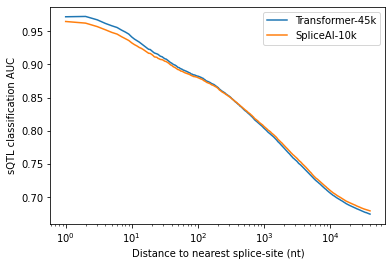

In [26]:
plt.semilogx(ds,aucs_1,label='Transformer-45k')
plt.semilogx(ds,aucs_2,label='SpliceAI-10k')
plt.ylabel('sQTL classification AUC')
plt.xlabel('Distance to nearest splice-site (nt)')
plt.legend()
plt.savefig('../Results/sQTL_delta_AUC_161023.png',dpi=300,bbox_inches='tight')
plt.show()

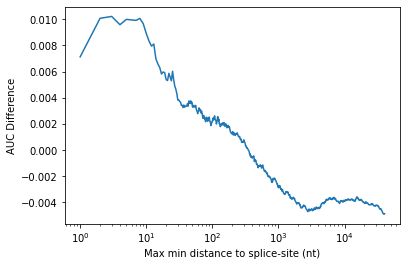

In [27]:
plt.semilogx(ds,np.array(aucs_1)-np.array(aucs_2))
plt.ylabel('AUC Difference')
plt.xlabel('Max min distance to splice-site (nt)')
#plt.legend()
plt.savefig('../Results/sQTL_delta_AUC_210923.png',dpi=300)
plt.show()

In [28]:
from sklearn.metrics import average_precision_score

In [29]:
aucs_1 = []
aucs_2 = []
ds = np.logspace(0,4.605,1000)
ds = np.unique(np.round(ds)).astype(int)
for d in tqdm(ds):
    to_include = lead_sQTL['splice_event_id'][lead_sQTL[['acceptor','donor']].abs().min(axis=1)<=d].values
    df_transformer_cond = df_transformer[df_transformer['splice_event_id'].isin(to_include)]
    df_spliceai_cond = df_spliceai[df_spliceai['splice_event_id'].isin(to_include)]
    delta_transformer = df_transformer_cond[['top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']].max(axis=1).values
    delta_spliceai = df_spliceai_cond[['top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']].max(axis=1).values
    #fpr1, tpr1,t1 = roc_curve(df_transformer_cond['is_sQTL'], delta_transformer)
    auc_1 = average_precision_score(df_transformer_cond['is_sQTL'], delta_transformer)
    #plt.plot(fpr1, tpr1,label=f"Transformer-40k (AUC = {auc_1 :.3f})")
    #fpr2, tpr2,t2 = roc_curve(df_spliceai_cond['is_sQTL'], delta_spliceai)
    #auc_2 = auc(fpr2, tpr2)
    auc_2 = average_precision_score(df_spliceai_cond['is_sQTL'], delta_spliceai)
    aucs_1.append(auc_1)
    aucs_2.append(auc_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 665/665 [01:15<00:00,  8.81it/s]


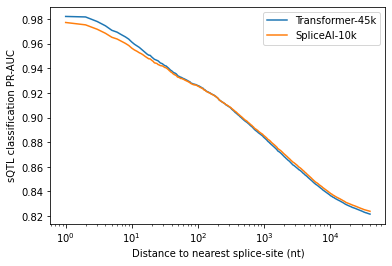

In [30]:
plt.semilogx(ds,aucs_1,label='Transformer-45k')
plt.semilogx(ds,aucs_2,label='SpliceAI-10k')
plt.ylabel('sQTL classification PR-AUC')
plt.xlabel('Distance to nearest splice-site (nt)')
plt.legend()
plt.savefig('../Results/sQTL_delta_PR_AUC_161023.png',dpi=300,bbox_inches='tight')
plt.show()

In [31]:
from scipy.stats import spearmanr

In [32]:
delta_transformer.shape

(103876,)

In [33]:
delta_spliceai.shape

(103876,)

SpearmanrResult(correlation=0.8638968677675862, pvalue=0.0)


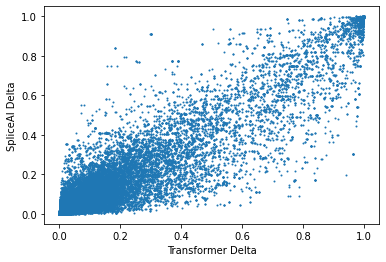

In [34]:
plt.scatter(delta_transformer,delta_spliceai,s=1)
plt.xlabel('Transformer Delta')
plt.ylabel('SpliceAI Delta')
#plt.colorbar()
print(spearmanr(delta_transformer,delta_spliceai))
plt.show()

In [35]:
results_transformer = df_transformer.merge(lead_sQTL,on='splice_event_id')

In [36]:
results_spliceai = df_spliceai.merge(lead_sQTL,on='splice_event_id')

In [37]:
variant_anno = pd.read_csv('/nfs/odinn/users/gislih/RNA/requests/rna_paper/splice_anno/clover_snpindel_filtered_junctions_reannotated.01-12-2021.tsv.gz',sep='\t')

In [38]:
splice_event_id = []
for i in tqdm(range(variant_anno.shape[0])):
    chrom,start,end = variant_anno.iloc[i,:]['Chrom'],variant_anno.iloc[i,:]['Start'],variant_anno.iloc[i,:]['End']
    splice_event_id.append(f'{chrom}:{start}:{end}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 127016/127016 [01:11<00:00, 1782.19it/s]


In [39]:
variant_anno['splice_event_id_2'] = splice_event_id

In [40]:
lead_sQTL['splice_event_id_2'] = lead_sQTL['splice_event_id'].apply(lambda x: ':'.join(x.split(':')[:-1]))

In [41]:
tmp = lead_sQTL.merge(variant_anno[['splice_event_id_2','Name','variant_type']],on=['splice_event_id_2','Name'])

In [42]:
disrupting_variant = tmp[tmp['variant_type']=='disrupting']['splice_event_id'].values
creating_variant = tmp[tmp['variant_type']=='creating']['splice_event_id'].values

In [43]:
disrupting = df_transformer[df_transformer['splice_event_id'].isin(disrupting_variant)]

fpr1, tpr1,t1 = roc_curve(disrupting['is_sQTL'],np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1))
auc_1 = auc(fpr1, tpr1)
#plt.plot(fpr1, tpr1,label=f"Transformer-40k (AUC = {auc_1 :.3f})")


In [44]:
x1 = np.sum(np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1)[disrupting['is_sQTL']==1]>0.1)
x2 = np.sum(disrupting['is_sQTL'])
print(x1/x2,x1,x2)

0.886039886039886 311 351


In [45]:
disrupting = df_spliceai[df_spliceai['splice_event_id'].isin(disrupting_variant)]
fpr2, tpr2,t2 = roc_curve(disrupting['is_sQTL'],np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1))
auc_2 = auc(fpr2, tpr2)

In [46]:
x1 = np.sum(np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1)[disrupting['is_sQTL']==1]>0.1)
x2 = np.sum(disrupting['is_sQTL'])
print(x1/x2,x1,x2)

0.8148148148148148 286 351


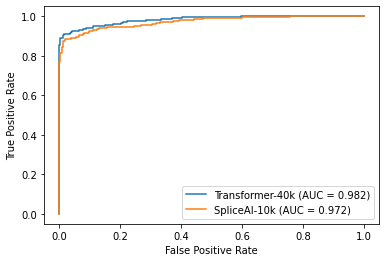

In [47]:
plt.plot(fpr1,tpr1,label=f'Transformer-40k (AUC = {auc_1:.3f})')
plt.plot(fpr2,tpr2,label=f'SpliceAI-10k (AUC = {auc_2:.3f})')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.savefig('../Results/sQTL_splice_disruption_delta_AUC.png',dpi=300,bbox_inches='tight')
plt.show()

In [48]:
auc_1

0.9824676747753671

In [49]:
auc_2

0.971553802323033

260 351


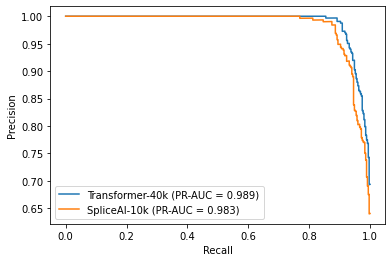

In [50]:
#tmp = results[results['label'].isin(['upstr_intron','downstr_intron'])]
#tmp = results[['is_sdv','top_d_disruption_delta_y','top_a_disruption_delta_y','top_d_disruption_delta_x','top_a_disruption_delta_x','top_d_disruption_delta_x','top_a_disruption_delta_x']].dropna()
disrupting = df_transformer[df_transformer['splice_event_id'].isin(disrupting_variant)]
X1,y1 = np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1),disrupting['is_sQTL']
disrupting = df_spliceai[df_spliceai['splice_event_id'].isin(disrupting_variant)]
X2,y2 = np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1),disrupting['is_sQTL']

precision1, recall1,t1 = precision_recall_curve(y1, X1)
auc_1 = average_precision_score(y1, X1)

#aucs_1.append(auc_1)
plt.plot(recall1,precision1,label=f"Transformer-40k (PR-AUC = {auc_1 :.3f})")

precision2, recall2,t2 = precision_recall_curve(y2, X2)
auc_2 = average_precision_score(y2, X2)

#aucs_1.append(auc_1)
plt.plot(recall2,precision2,label=f"SpliceAI-10k (PR-AUC = {auc_2 :.3f})")


plt.ylabel("Precision")
plt.xlabel("Recall")
print(np.sum(y2==0),np.sum(y2==1))
plt.legend()
#plt.savefig('../Results/sQTL_splice_disruption_delta_PRC.png',dpi=300,bbox_inches='tight')
plt.show()

In [51]:
creating = df_transformer[df_transformer['splice_event_id'].isin(creating_variant)]
x1 = np.sum(np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1)[creating['is_sQTL']==1]>0.1)
x2 = np.sum(creating['is_sQTL'])
print(x1/x2,x1,x2)
fpr1, tpr1,t1 = roc_curve(creating['is_sQTL'],np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1))
auc_1 = auc(fpr1, tpr1)
creating = df_spliceai[df_spliceai['splice_event_id'].isin(creating_variant)]
x1 = np.sum(np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1)[creating['is_sQTL']==1]>0.1)
x2 = np.sum(creating['is_sQTL'])
print(x1/x2,x1,x2)
fpr2, tpr2,t2 = roc_curve(creating['is_sQTL'],np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1))
auc_2 = auc(fpr2, tpr2)

0.8869814020028612 620 699
0.7982832618025751 558 699


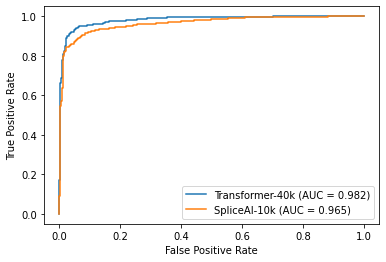

In [52]:
plt.plot(fpr1,tpr1,label=f'Transformer-40k (AUC = {auc_1:.3f})')
plt.plot(fpr2,tpr2,label=f'SpliceAI-10k (AUC = {auc_2:.3f})')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.savefig('../Results/sQTL_splice_creation_delta_AUC.png',dpi=300,bbox_inches='tight')
plt.show()

In [53]:
auc_1

0.9821173104434907

In [54]:
auc_2

0.9646925261195647

528 699


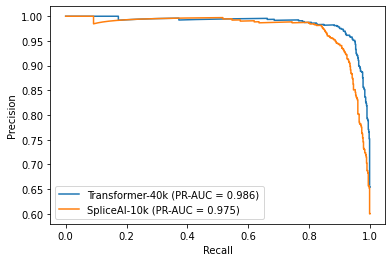

In [55]:
creating = df_transformer[df_transformer['splice_event_id'].isin(creating_variant)]
X1,y1 = np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1),creating['is_sQTL']
creating = df_spliceai[df_spliceai['splice_event_id'].isin(creating_variant)]
X2,y2 = np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1),creating['is_sQTL']

precision1, recall1,t1 = precision_recall_curve(y1, X1)
auc_1 = average_precision_score(y1, X1)

#aucs_1.append(auc_1)
plt.plot(recall1,precision1,label=f"Transformer-40k (PR-AUC = {auc_1 :.3f})")

precision2, recall2,t2 = precision_recall_curve(y2, X2)
auc_2 = average_precision_score(y2, X2)

#aucs_1.append(auc_1)
plt.plot(recall2,precision2,label=f"SpliceAI-10k (PR-AUC = {auc_2 :.3f})")


plt.ylabel("Precision")
plt.xlabel("Recall")
print(np.sum(y2==0),np.sum(y2==1))
plt.legend()
#plt.savefig('../Results/sQTL_splice_creation_delta_PRC.png',dpi=300,bbox_inches='tight')
plt.show()

In [56]:
both = df_transformer[df_transformer['splice_event_id'].isin(np.concatenate([creating_variant,disrupting_variant]))]
fpr1, tpr1,t1 = roc_curve(both['is_sQTL'],np.max(both[['top_a_disruption_delta','top_d_disruption_delta','top_a_creation_delta','top_d_creation_delta']],axis=1))
auc_1 = auc(fpr1, tpr1)
both = df_spliceai[df_spliceai['splice_event_id'].isin(np.concatenate([creating_variant,disrupting_variant]))]
fpr2, tpr2,t2 = roc_curve(both['is_sQTL'],np.max(both[['top_a_disruption_delta','top_d_disruption_delta','top_a_creation_delta','top_d_creation_delta']],axis=1))
auc_2 = auc(fpr2, tpr2)

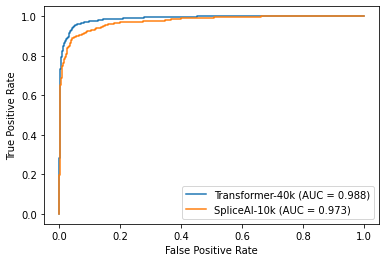

In [57]:
plt.plot(fpr1,tpr1,label=f'Transformer-40k (AUC = {auc_1:.3f})')
plt.plot(fpr2,tpr2,label=f'SpliceAI-10k (AUC = {auc_2:.3f})')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('../Results/sQTL_splice_creation_and_disruption_delta_AUC_210923.png',dpi=300,bbox_inches='tight')
plt.show()

In [58]:
auc_1

0.9879550398839738

In [59]:
auc_2

0.9734191443074691

788 1050


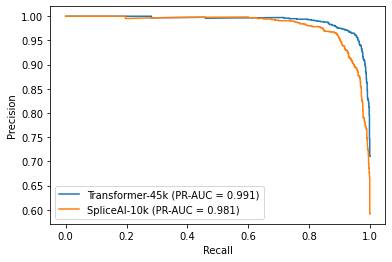

In [60]:
both = df_transformer[df_transformer['splice_event_id'].isin(np.concatenate([creating_variant,disrupting_variant]))]
y1, X1 = both['is_sQTL'],np.max(both[['top_a_disruption_delta','top_d_disruption_delta','top_a_creation_delta','top_d_creation_delta']],axis=1)
both = df_spliceai[df_spliceai['splice_event_id'].isin(np.concatenate([creating_variant,disrupting_variant]))]
y2, X2 = both['is_sQTL'],np.max(both[['top_a_disruption_delta','top_d_disruption_delta','top_a_creation_delta','top_d_creation_delta']],axis=1)
precision1, recall1,t1 = precision_recall_curve(y1, X1)
auc_1 = average_precision_score(y1, X1)

#aucs_1.append(auc_1)
plt.plot(recall1,precision1,label=f"Transformer-45k (PR-AUC = {auc_1 :.3f})")

precision2, recall2,t2 = precision_recall_curve(y2, X2)
auc_2 = average_precision_score(y2, X2)

#aucs_1.append(auc_1)
plt.plot(recall2,precision2,label=f"SpliceAI-10k (PR-AUC = {auc_2 :.3f})")


plt.ylabel("Precision")
plt.xlabel("Recall")
print(np.sum(y2==0),np.sum(y2==1))
plt.legend()
plt.savefig('../Results/sQTL_splice_creation_and_disruption_delta_PRC_161023.png',dpi=300,bbox_inches='tight')
plt.show()


In [61]:
both = df_transformer[df_transformer['splice_event_id'].isin(np.concatenate([creating_variant,disrupting_variant]))]
to_check = both[np.max(both[['top_a_disruption_delta','top_d_disruption_delta','top_a_creation_delta','top_d_creation_delta']],axis=1)<0.1].index

In [62]:
lowScore = np.max(both[['top_a_disruption_delta','top_d_disruption_delta','top_a_creation_delta','top_d_creation_delta']],axis=1)>0.1
to_check = both[np.all([lowScore,both['is_sQTL']==True],axis=0)]['splice_event_id'].values

In [63]:
tmp[tmp['splice_event_id'].isin(to_check)]

,Chrom,Pos,Name,rsids,splice_event_id,Gene_name,Pval,log10_Pval,Effect,X2,...,ClusterID,Strand,jct_prevalence,is_annotated,donor,acceptor,Pos_bin,num_tests,splice_event_id_2,variant_type
1,chr1,1049997,chr1:1049997:SG,rs113020870,chr1:1049995:1050232:28,AGRN,2.669645e-19,-18.573547,2.983547,80.668346,...,28,+,0.000504,False,2,-236,D+2,1060,chr1:1049995:1050232,creating
2,chr1,1063202,chr1:1063202:SG,rs3813194,chr1:1063201:1065829:32,RP11-465B22.3,3.131610e-82,-81.504232,0.817176,368.973170,...,32,+,0.037147,True,1,-2628,D+1,686,chr1:1063201:1065829,creating
3,chr1,1082984,chr1:1082984:SG,rs139658850,chr1:1082982:1084352:34,C1orf159,1.295399e-20,-19.887596,1.527281,86.649857,...,34,-,0.001065,False,1369,-2,A-2,1058,chr1:1082982:1084352,creating
6,chr1,1295596,chr1:1295596:XG:1,NaN,chr1:1295595:1295735:57,ACAP3,7.036776e-126,-125.152626,1.802991,569.549219,...,57,-,0.006163,False,140,-1,A-1,900,chr1:1295595:1295735,creating
14,chr1,2392128,chr1:2392128:SG,rs2935277,chr1:2392126:2395783:172,RER1,0.000000e+00,-2516.184971,-1.028017,11577.651425,...,172,+,0.811968,False,2,-3656,D+2,829,chr1:2392126:2395783,disrupting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,chr9,136854337,chr9:136854337:SG,rs138147005,chr9:136854336:136854538:1948,MAMDC4,5.479996e-49,-48.261220,-2.670826,216.413221,...,1948,+,0.451143,True,1,-202,D+1,582,chr9:136854336:136854538,disrupting
3094,chr9,137013469,chr9:137013469:SG,rs201649376,chr9:137013318:137013470:1996,ABCA2,2.587326e-98,-97.587149,1.939596,442.856110,...,1996,-,0.004314,False,2,-151,D+2,719,chr9:137013318:137013470,creating
3095,chr9,137087017,chr9:137087017:SG,rs748924159,chr9:137087015:137088074:2023,MAN1B1,1.987007e-18,-17.701801,2.009470,76.703006,...,2023,+,0.000616,False,2,-1058,D+2,842,chr9:137087015:137088074,creating
3097,chr9,137464393,chr9:137464393:SG,rs202021065,chr9:137464391:137467316:2101,PNPLA7,2.544418e-20,-19.594412,3.071300,85.314876,...,2101,-,0.000448,False,2924,-2,A-2,1292,chr9:137464391:137467316,creating


In [64]:
tmp[tmp['splice_event_id']=='chr9:136854336:136854538:1948']

,Chrom,Pos,Name,rsids,splice_event_id,Gene_name,Pval,log10_Pval,Effect,X2,...,ClusterID,Strand,jct_prevalence,is_annotated,donor,acceptor,Pos_bin,num_tests,splice_event_id_2,variant_type
3091,chr9,136854337,chr9:136854337:SG,rs138147005,chr9:136854336:136854538:1948,MAMDC4,5.479996e-49,-48.26122,-2.670826,216.413221,...,1948,+,0.451143,True,1,-202,D+1,582,chr9:136854336:136854538,disrupting


In [61]:
tmp[tmp['splice_event_id']=='chr9:35829391:35829876:421']

,Chrom,Pos,Name,rsids,splice_event_id,Gene_name,Pval,log10_Pval,Effect,X2,...,ClusterID,Strand,jct_prevalence,is_annotated,donor,acceptor,Pos_bin,num_tests,splice_event_id_2,variant_type
3248,chr9,35829393,chr9:35829393:SG,rs2381409,chr9:35829391:35829876:421,TMEM8B,1.415976e-31,-30.848944,-0.744711,136.681031,...,421,+,0.036419,True,2,-484,D+2,612,chr9:35829391:35829876,disrupting


In [62]:
gtex_anno = pd.read_csv('/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8/annotation_GTEX_v8.txt',sep='\t',header=None)

In [63]:
gtex_anno[gtex_anno[0]=='MAMDC4'][8].values

array(['136852462,136853209,136853458,136853670,136853907,136854076,136854336,136854676,136854850,136855110,136855338,136855619,136855848,136856149,136856826,136857041,136857298,136857586,136857796,136858097,136858276,136858546,136858853,136859132,136859317,136860064,136853650,136853896,136854360,136856348,136856381,136856575,136857291,136858824,136859125'],
      dtype=object)

In [64]:
gtex_anno[gtex_anno[0]=='MAMDC4'][9].values

array(['136853102,136853285,136853545,136853777,136853992,136854211,136854539,136854762,136854937,136855254,136855431,136855732,136856018,136856710,136856907,136857165,136857367,136857659,136857979,136858186,136858400,136858719,136859005,136859209,136859886,136860562,136853099,136853142,136853075,136853751,136854952,136855644,136856257,136856630,136856464,136856934'],
      dtype=object)

In [65]:
gtex_anno[gtex_anno[0]=='TMEM8B'][8].values

array(['35829955,35834650,35835218,35841267,35841794,35842717,35846068,35846381,35846611,35846995,35852973,35853257,35825895,35828832,35828944,35832753,35833555,35834378,35835441,35838232,35843531,35845829,35845885,35846073,35854112'],
      dtype=object)

In [66]:
gtex_anno[gtex_anno[0]=='TMEM8B'][9].values

array(['35834461,35835011,35841134,35841526,35842392,35845975,35846258,35846469,35846817,35852827,35853141,35853505,35832600,35834531,35835288,35838178,35841541,35841630,35845708,35845808,35843365,35845736,35849535,35853980,35853509,35894803,35863791'],
      dtype=object)